In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# +수치는 유입, -수치는 유출을 의미
# +1은 마지막 숫자 5를 생략하면 안됩니다. 주의하세요
actions = np.arange(-5,5+1) 
actions

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5])

In [40]:
# 상태를 정의하겠습니다. 
# 직영점 하나에 대해 0을 포함한 최대 주차대수는 20대 -> 21가지
states = []
for i in range(20+1):
    for j in range(20+1):
        states.append([i,j])

In [41]:
# 가치함수, 업데이트 용 가치함수
value = np.zeros((20+1, 20+1))
new_value = np.zeros((20+1,20+1))

In [42]:
value.shape

(21, 21)

In [43]:
# 정책 정의 -> 21*21 행렬
policy = np.zeros((20+1, 20+1))
new_policy = np.zeros((20+1,20+1))

In [44]:
# 포아송 분포 -> 메모이제이션
p_dict = {}

def poisson_distribution(x,lamb):
    global p_dict
    key = (x,lamb)
    if key not in p_dict.keys():
        p_dict[key] = lamb**x*np.exp(-lamb)/np.math.factorial(x)
    return p_dict[key]

In [45]:
poisson_distribution(12,3)

5.5237580418282494e-05

In [46]:
# 고객들이 실질적으로 대여할 차량의 수 11대, 12대 빌릴 확률은 5.524e-05
poisson_upper_bound = 11+1

In [47]:
def Caculate_nextV_function(state,action,state_value,gamma=0.9):
    '''
    입력인자
        state: A직영점, B직영점 각각의 차량대수, 리스트, [i,j] 0~20사이의 정수
        action: A -> B으로의 움직일 차량대수, 스칼라, -5~5사이의 정수
        state_value: 현재 계산된 가치함수, 21*21의 행렬
    출력인자
        returns: 기대 가치함수, 스칼라 
        R+gamma*sum(P_{ss'}^{action}*V(s'))
    '''
    # 이동대수에 대한 패널티
    returns = -2*np.abs(action)
    
    # 현재상태 - 이동함으로써 변화하는 차량대수
    A_cars = int(min(state[0]-action,20))
    B_cars = int(min(state[1]+action,20))
    
    for rentA in range(poisson_upper_bound):
        for rentB in range(poisson_upper_bound):
            # 대여 확률 = A직영점 대여확률 x B직영점 대여확률 (독립사건)
            rent_prob = poisson_distribution(rentA,3)*poisson_distribution(rentB,3)
            
            # 직영점간 최종 차량 대여 수 및 보상(대여할수 있는 차량은 가지고 있는 차량까지!)
            Alot_rent_fin = min(A_cars,rentA)
            Blot_rent_fin = min(B_cars,rentB)
            reward = (Alot_rent_fin+Blot_rent_fin)*10
            
            for returnA in range(poisson_upper_bound):
                for returnB in range(poisson_upper_bound):
                    # 반납 확률 = A직영점 반납확률 x B직영점 반납확률 (독립사건)
                    return_prob = poisson_distribution(returnA,3)*poisson_distribution(returnB,2)
                    
                    # 다음상태 - 대여(-), 반납(+)
                    next_A_cars = int(min(A_cars-Alot_rent_fin+returnA,20))
                    next_B_cars = int(min(B_cars-Blot_rent_fin+returnB,20))
                    #next_A_cars = int(min(state[0]-Alot_rent_fin+returnA,20))
                    #next_B_cars = int(min(state[1]-Blot_rent_fin+returnB,20))

                    #최종 확률 = 대여확률 x 반납확률 (독립사건)
                    total_prob = rent_prob*return_prob
                    
                    # 기대 가치함수 
                    returns += total_prob*(reward+gamma*state_value[next_A_cars,next_B_cars])
    return returns

In [48]:
iter_policy = []
iter_value = []
iter_policy.append(policy)
iter_value.append(value)

In [49]:
for it in range(3):
    print(f'반복회차: {it+1}')
    for i,j in states:
        action_buffer = []
        for action in actions:
            action_buffer.append(Caculate_nextV_function([i,j],action,value))
        act_idx = np.argmax(action_buffer)
        new_policy[i,j] = actions[act_idx]
        new_value[i,j] = np.max(action_buffer)#Caculate_nextV_function([i,j],actions[act_idx],value)

    value = new_value.copy()
    policy = new_policy.copy()
    
    iter_policy.append(policy)
    iter_value.append(value)

반복회차: 1
반복회차: 2
반복회차: 3


/tmp/ipykernel_69640/4046970571.py:2: UserWarning: The following kwargs were not used by contour: 'level'
  cs = ax.contour(policy,level=10,colors='k')


Text(0.5, 1.0, 'Policy')

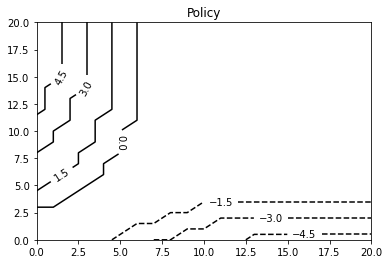

In [50]:
fig,ax = plt.subplots()
cs = ax.contour(policy,level=10,colors='k')
ax.clabel(cs,inline=1,fontsize=10)
ax.set_title("Policy")

/tmp/ipykernel_69640/3842860361.py:2: UserWarning: The following kwargs were not used by contour: 'level'
  cs = ax.contour(value,level=10,colors='k')


Text(0.5, 1.0, 'Expected return')

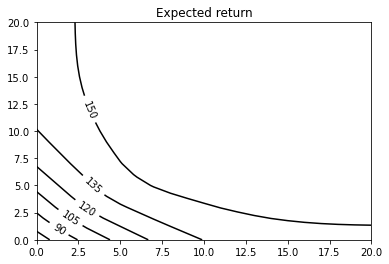

In [51]:
fig,ax = plt.subplots()
cs = ax.contour(value,level=10,colors='k')
ax.clabel(cs,inline=1,fontsize=10)
ax.set_title("Expected return")

In [52]:
np.save('./3장_잭카_반복policy',iter_policy)
np.save('./3장_잭카_반복value',iter_value)

/tmp/ipykernel_69640/1313141598.py:3: UserWarning: No contour levels were found within the data range.
  cs = ax.contour(ip,level=10,colors='k')
/tmp/ipykernel_69640/1313141598.py:3: UserWarning: The following kwargs were not used by contour: 'level'
  cs = ax.contour(ip,level=10,colors='k')


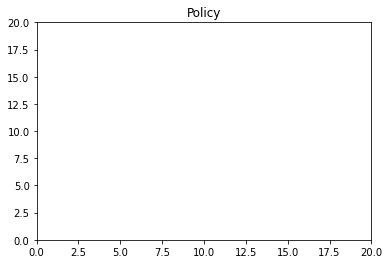

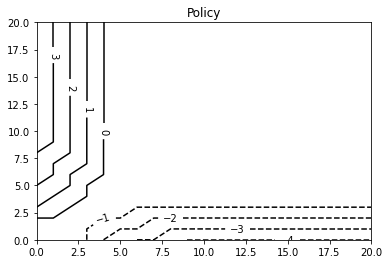

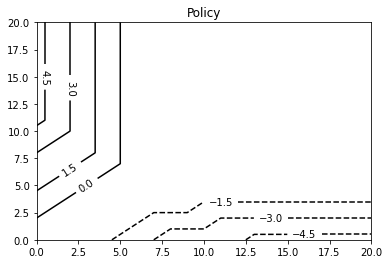

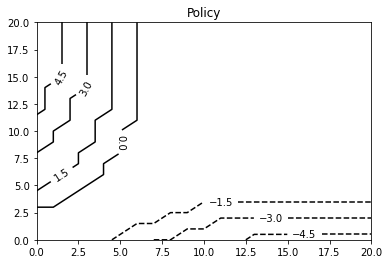

In [53]:
for ip in iter_policy:
    fig,ax = plt.subplots()
    cs = ax.contour(ip,level=10,colors='k')
    ax.clabel(cs,inline=1,fontsize=10)
    ax.set_title("Policy")

/tmp/ipykernel_69640/1660589410.py:3: UserWarning: No contour levels were found within the data range.
  cs = ax.contour(iv,level=10,colors='k')
/tmp/ipykernel_69640/1660589410.py:3: UserWarning: The following kwargs were not used by contour: 'level'
  cs = ax.contour(iv,level=10,colors='k')


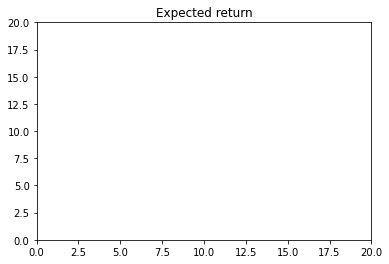

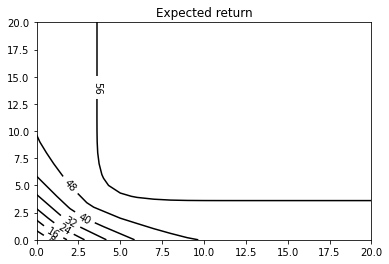

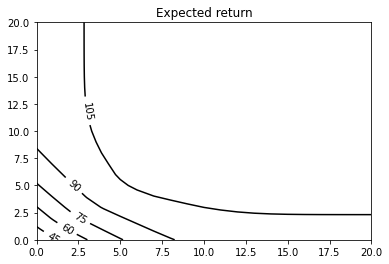

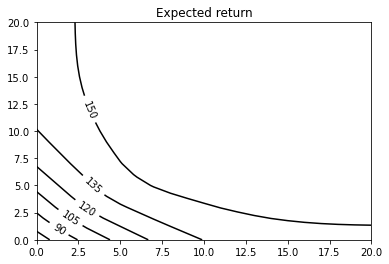

In [54]:
for iv in iter_value:
    fig,ax = plt.subplots()
    cs = ax.contour(iv,level=10,colors='k')
    ax.clabel(cs,inline=1,fontsize=10)
    ax.set_title("Expected return")